In [1]:
!python --version

Python 3.7.16


In [1]:
from Agent import Agent
#from NegotiationNet import NegotiationNet

import torch

import numpy as np
import pandas as pd

import os
os.chdir("..")
from rice_nego import Rice

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# envs_2_regions = [Rice(region_yamls_filename='2_region_yamls/') for _ in range(5)]
# initial_state_2 = envs_2_regions[0].reset()

# envs_4_regions = [Rice(region_yamls_filename='identical_region_yamls/') for _ in range(5)]
# initial_state_4 = envs_4_regions[0].reset()

In [3]:
# agents_2 = [Agent(envs_2_regions[0], initial_state_2[agent_id], agent_id) 
#             for agent_id in range(envs_2_regions[0].num_agents)]
# agents_4 = [Agent(envs_4_regions[0], initial_state_4[agent_id], agent_id) 
#             for agent_id in range(envs_4_regions[0].num_agents)]

In [2]:
def create_agent(env, state, id):
    return Agent(len(state[id]['features']), env.action_space[id], env.num_regions, env.message_length, id = id)

In [3]:
envs = [Rice(id = i, region_yamls_filename='2_region_yamls//', num_discrete_action_levels=5) for i in range(5)]
initial_state = envs[0].reset()
agents = [create_agent(envs[0], initial_state, agent_id) for agent_id in range(envs[0].num_regions)]

In [4]:
def negotiate_proposals(agents, envs, states, step):
    
    # Act
    collective_action = {}
    for agent in agents:
        collective_action[agent.id] = agent.negotiate(
            [state[agent.id] for state in states],
            save_map = {
                'save_state' : True,
                'save_decisions' : False,
                'save_proposals_promises' : True
            }
        )
        
    # Register actions in the environment and take rewards
    all_rewards, new_states = [], []
    for env_id in range(len(envs)):
        state, rewards = envs[env_id].register_proposals({
            agent_id: {
                identifier: action[env_id]
                for identifier, action in action_dict.items()
            }
            for agent_id, action_dict in collective_action.items()
        }, step)
        
        all_rewards.append(rewards)
        new_states.append(state)
        
    return new_states, np.array(all_rewards)
    

In [5]:
def negotiate_decisions(agents, envs, states, step):
    
    # Act
    collective_action = {}
    for agent in agents:
        collective_action[agent.id] = agent.negotiate(
            [state[agent.id] for state in states],
            save_map = {
                'save_state' : False,
                'save_decisions' : True,
                'save_proposals_promises' : False
            }
        )
        
    # Register actions in the environment and take rewards
    all_rewards, new_states = [], []
    for env_id in range(len(envs)):
        state, rewards = envs[env_id].register_decisions({
            agent_id: {
                identifier: action[env_id]
                for identifier, action in action_dict.items()
            }
            for agent_id, action_dict in collective_action.items()
        }, step)
        
        all_rewards.append(rewards)
        new_states.append(state)
        
    return new_states, np.array(all_rewards)

In [6]:
def act_collectively(agents, envs, states, with_mask = True):
    collective_action = {}
    for agent in agents:
        collective_action[agent.id] = agent.act(
            [state[agent.id] for state in states],
            with_mask = with_mask
        )
        
    states, rewards, _, _ = zip(*[
        env.step({agent_id : collective_action[agent_id][i] 
                for agent_id in range(len(agents))}) 
        for (i, env) in enumerate(envs)
    ])
    return states, rewards

In [ ]:
# rs_difference = {agent.id : [] for agent in agents}
rs_negotiation = {agent.id : [] for agent in agents}

episode_length = envs[0].episode_length
negotiation_steps = envs[0].max_negotiation_steps

# The terminal states are the same every time
is_terminals = np.zeros(len(envs) * negotiation_steps, dtype = bool)
is_terminals[range(negotiation_steps - 1, len(is_terminals), negotiation_steps)]

for epoch in tqdm(range(10)):
    
    for batch in range(2):
        states = [env.reset() for env in envs]
        for t in range(episode_length):
            
            for agent in agents:
                agent.reset_negotiation_hs()

            all_rewards_proposals = [[]] * negotiation_steps
            all_rewards_decisions = [[]] * negotiation_steps
            
            for step in range(negotiation_steps):
                states, all_rewards_proposals[step] = negotiate_proposals(agents, envs, states, step)
                states, all_rewards_decisions[step] = negotiate_decisions(agents, envs, states, step)
            
            states, rewards = act_collectively(agents, envs, states)
            all_rewards_actions = np.array([list(reward.values()) for reward in rewards])
            
            all_rewards_actions_repeated = np.repeat(all_rewards_actions, negotiation_steps, axis = 0)
            all_rewards_decisions = np.concatenate(all_rewards_decisions) * all_rewards_actions_repeated
            all_rewards_proposals = np.concatenate(all_rewards_proposals) * all_rewards_actions_repeated
            
            
            for agent in agents:
                agent.nets['negotiationNet'].buffer.rewards_decisions.extend(all_rewards_decisions[:, agent.id])
                agent.nets['negotiationNet'].buffer.rewards_proposals.extend(all_rewards_proposals[:, agent.id])
                agent.nets['negotiationNet'].buffer.is_terminals.extend(is_terminals)
                agent.nets['activityNet'].buffer.rewards.extend(all_rewards_actions[:, agent.id])
                agent.nets['activityNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))
    for agent in agents:
        agent.update()

  0%|                                                                                                | 0/10 [00:00<?, ?it/s]

{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0

 10%|████████▊                                                                               | 1/10 [00:02<00:24,  2.67s/it]

{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0

 20%|█████████████████▌                                                                      | 2/10 [00:05<00:20,  2.62s/it]

{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0

 30%|██████████████████████████▍                                                             | 3/10 [00:07<00:17,  2.49s/it]

{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0

 40%|███████████████████████████████████▏                                                    | 4/10 [00:10<00:15,  2.52s/it]

{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: False}, 1: {0: False}} {0: {1: array([0])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: 

 50%|████████████████████████████████████████████                                            | 5/10 [00:12<00:12,  2.51s/it]

{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([1])}}
{0: {1: False}, 1: {0: False}} {0: {1: array([0])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: False}, 1: {0: False}} {0: {1: array([0])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([0])}, 1: {0: array([1])}}
{0: {1: True}, 1: {0: True}} {0: {1: array([1])}, 1: {0: array([0])}}
{0: {1: True}, 1

 60%|████████████████████████████████████████████████████▊                                   | 6/10 [00:15<00:10,  2.53s/it]

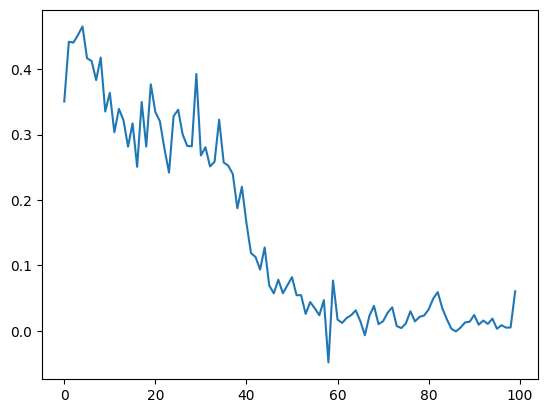

In [11]:
plt.plot(np.array(agents[1].nets['activityNet'].loss_collection).reshape(100, -1).mean(axis = 1))

In [16]:
envs[0].decisions

{0: {1: array(0)}, 1: {0: array(0)}}